#### TRABALHO FINAL DA DISCIPLINA − MINERAÇÃO DE TEXTO E DA WEB – 2021.1

Aluno: Daniel Moraes e Ricardo Vasconselos

Objetivos: Desenvolver um classificador para a tarefa de detecção de inferência entre duas sentenças em linguagem natural. Dada duas sentenças em linguagem natural (Português), o classificador deve definir a relação de inferência entre ambas:

Neutra
Implicação (A -> B): posso inferior B a partir de A


Contradição: A contradiz B, ou B contradiz A

Será fornecido um dataset com 9000 pares de sentenças rotuladas (com os resultados), para treinamento e validação.

As equipes serão avaliadas pelos entregáveis e pelos resultados a partir de um conjunto de teste (dados não vistos – Held-Out Data) com 1000 pares de sentenças.

#### Produtos Entregáveis:

Pré-processamento, Steemer, Lematização e POS Tagger, NER, etc (31/05/2021)

Vetorização das Sentenças (features)

Model Fitted e Resultados do processo de treinamento (28/06/2021)

Execução com Held-Out-Data (Dados não vistos) (12/07/2021)

Artigo resumo com 4 paginas (12/07/2021)

Apresentação Oral e Entrega do artigo: 05/07/2021 e 12/07/2021

#### IMPORTACAO E INSTALAÇÃO DE BIBLIOTECAS, GPUS ETC

In [48]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [49]:
pip install --upgrade jupyter_http_over_ws>=0.0.7 && \
  jupyter serverextension enable --py jupyter_http_over_ws

Traceback (most recent call last):
  File "/usr/local/bin/jupyter-serverextension", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/jupyter_core/application.py", line 267, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/notebook/serverextensions.py", line 293, in start
    super(ServerExtensionApp, self).start()
  File "/usr/local/lib/python2.7/dist-packages/jupyter_core/application.py", line 256, in start
    self.subapp.start()
  File "/usr/local/lib/python2.7/dist-packages/notebook/serverextensions.py", line 210, in start
    self.toggle_server_extension_python(arg)
  File "/usr/local/lib/python2.7/dist-packages/notebook/serverextensions.py", line 199, in toggle_server_extension_python
    m, server_exts = _get_server_extension_meta

In [50]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [51]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
import random
import string
import seaborn as sns
from google.colab import drive
import spacy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 

In [61]:
#Pacotes NLTK
import nltk
import re
import string
nltk.download('maxent_ne_chunker', quiet=True)
nltk.download('words', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('rslp', quiet=True)
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords as sw
from contextlib import redirect_stdout
from nltk.stem import PorterStemmer
from nltk.stem import RSLPStemmer
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import TweetTokenizer 
from nltk.stem import WordNetLemmatizer 
from nltk.stem import RSLPStemmer
from nltk.text import TextCollection
from collections import defaultdict
import os
from pprint import pprint
import joblib

#Download das stopwords
with redirect_stdout(open(os.devnull, "w")):
    nltk.download("stopwords", quiet=True) 
    nltk.download('punkt', quiet=True)

In [53]:
!pip install bert-for-tf2
!pip install sentencepiece
!python3 -m spacy download pt
!pip install transformers
!pip install tensorflow==2.2.0-rc3
!pip install torchvision 

✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')


In [54]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import bert
tf.__version__

'2.2.0-rc3'

In [55]:
import torch
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


#### Pré-processamento, Steemer, Lematização e POS Tagger, NER, Vetorização (31/05/2021)

#### Tratamento inicial do texto

Converte o texto de cada sentença, separadamente, em minúsculo e remove espaços e tabulações extras. O resultado é guardado no DataFrame referente a cada sentenca em uma nova coluna.

In [56]:
#Importando o Dataset
df = pd.read_csv('Dataset_SICK_BR_Treinamento.csv', delimiter=';', encoding= 'mac_roman')

#conversão da coluna 'pair_ID' de inteiro para string
df['pair_ID'] = df['pair_ID'].astype('str')

#Visualização do Cabeçalho dos dados
df.head()

,pair_ID,sentence_A,sentence_B,entailment_label,relatedness_score,entailment_AB,entailment_BA,sentence_A_original,sentence_B_original,sentence_A_dataset,sentence_B_dataset
0,1,Um grupo de crianças está brincando em um quin...,Um grupo de meninos em um quintal está brincan...,NEUTRAL,4.5,A_neutral_B,B_neutral_A,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,FLICKR,FLICKR
1,2,Um grupo de crianças está brincando na casa e ...,Um grupo de crianças está brincando em um quin...,NEUTRAL,3.2,A_contradicts_B,B_neutral_A,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,FLICKR,FLICKR
2,3,Os meninos jovens estão brincando ao ar livre ...,As crianças estão brincando ao ar livre perto ...,ENTAILMENT,4.7,A_entails_B,B_entails_A,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,FLICKR,FLICKR
3,4,Os meninos jovens estão brincando ao ar livre ...,Não tem nenhum menino brincando ao ar livre e ...,CONTRADICTION,3.6,A_contradicts_B,B_contradicts_A,The young boys are playing outdoors and the ma...,There is no boy playing outdoors and there is ...,FLICKR,FLICKR
4,5,As crianças estão brincando ao ar livre perto ...,Um grupo de crianças está brincando em um quin...,NEUTRAL,3.4,A_neutral_B,B_neutral_A,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,FLICKR,FLICKR


In [57]:
#Função para tratar o texto
def tratamento_texto(sentence):
  
  #remove as quebras de linha
  sentence = re.sub(r'\n', '', sentence)
  #substitui tabulações por um espaço em branco
  sentence = re.sub(r'\t', ' ', sentence)
  #substitui um ou mais espaços em branco por um espaço
  sentence= re.sub(r'\s+', ' ', sentence, flags=re.I)
  #&amp;
  #remove aspas e apóstofres
  sentence = re.sub('["‘’“”…]', '', sentence)
  return sentence

#cria uma nova coluna no dataframe 'sentence' com cada sentence tokenizado
df['texto_B_tratado'] = df['sentence_B'].apply(tratamento_texto)
df['texto_A_tratado'] = df['sentence_A'].apply(tratamento_texto)
#Exibe o resultado
df[df.columns[::-1]].head()

,texto_A_tratado,texto_B_tratado,sentence_B_dataset,sentence_A_dataset,sentence_B_original,sentence_A_original,entailment_BA,entailment_AB,relatedness_score,entailment_label,sentence_B,sentence_A,pair_ID
0,Um grupo de crianças está brincando em um quin...,Um grupo de meninos em um quintal está brincan...,FLICKR,FLICKR,A group of boys in a yard is playing and a man...,A group of kids is playing in a yard and an ol...,B_neutral_A,A_neutral_B,4.5,NEUTRAL,Um grupo de meninos em um quintal está brincan...,Um grupo de crianças está brincando em um quin...,1
1,Um grupo de crianças está brincando na casa e ...,Um grupo de crianças está brincando em um quin...,FLICKR,FLICKR,A group of kids is playing in a yard and an ol...,A group of children is playing in the house an...,B_neutral_A,A_contradicts_B,3.2,NEUTRAL,Um grupo de crianças está brincando em um quin...,Um grupo de crianças está brincando na casa e ...,2
2,Os meninos jovens estão brincando ao ar livre ...,As crianças estão brincando ao ar livre perto ...,FLICKR,FLICKR,The kids are playing outdoors near a man with ...,The young boys are playing outdoors and the ma...,B_entails_A,A_entails_B,4.7,ENTAILMENT,As crianças estão brincando ao ar livre perto ...,Os meninos jovens estão brincando ao ar livre ...,3
3,Os meninos jovens estão brincando ao ar livre ...,Não tem nenhum menino brincando ao ar livre e ...,FLICKR,FLICKR,There is no boy playing outdoors and there is ...,The young boys are playing outdoors and the ma...,B_contradicts_A,A_contradicts_B,3.6,CONTRADICTION,Não tem nenhum menino brincando ao ar livre e ...,Os meninos jovens estão brincando ao ar livre ...,4
4,As crianças estão brincando ao ar livre perto ...,Um grupo de crianças está brincando em um quin...,FLICKR,FLICKR,A group of kids is playing in a yard and an ol...,The kids are playing outdoors near a man with ...,B_neutral_A,A_neutral_B,3.4,NEUTRAL,Um grupo de crianças está brincando em um quin...,As crianças estão brincando ao ar livre perto ...,5


In [58]:
#Funcao para separar as sentenças
def separa_sentencas(texto):
  lista_sentencas = sent_tokenize(texto)
  nova_lista = []
  for sent in lista_sentencas:
    nova_lista.append(sent.strip())
  return nova_lista

#cria uma nova coluna no dataframe 'sentence' com cada sentence tokenizado
df['texto_B_em_sentencas'] = df['texto_B_tratado'].apply(separa_sentencas)
df['texto_A_em_sentencas'] = df['texto_A_tratado'].apply(separa_sentencas)
#Exibe o resultado
df[df.columns[::-1]].head()

,texto_A_em_sentencas,texto_B_em_sentencas,texto_A_tratado,texto_B_tratado,sentence_B_dataset,sentence_A_dataset,sentence_B_original,sentence_A_original,entailment_BA,entailment_AB,relatedness_score,entailment_label,sentence_B,sentence_A,pair_ID
0,[Um grupo de crianças está brincando em um qui...,[Um grupo de meninos em um quintal está brinca...,Um grupo de crianças está brincando em um quin...,Um grupo de meninos em um quintal está brincan...,FLICKR,FLICKR,A group of boys in a yard is playing and a man...,A group of kids is playing in a yard and an ol...,B_neutral_A,A_neutral_B,4.5,NEUTRAL,Um grupo de meninos em um quintal está brincan...,Um grupo de crianças está brincando em um quin...,1
1,[Um grupo de crianças está brincando na casa e...,[Um grupo de crianças está brincando em um qui...,Um grupo de crianças está brincando na casa e ...,Um grupo de crianças está brincando em um quin...,FLICKR,FLICKR,A group of kids is playing in a yard and an ol...,A group of children is playing in the house an...,B_neutral_A,A_contradicts_B,3.2,NEUTRAL,Um grupo de crianças está brincando em um quin...,Um grupo de crianças está brincando na casa e ...,2
2,[Os meninos jovens estão brincando ao ar livre...,[As crianças estão brincando ao ar livre perto...,Os meninos jovens estão brincando ao ar livre ...,As crianças estão brincando ao ar livre perto ...,FLICKR,FLICKR,The kids are playing outdoors near a man with ...,The young boys are playing outdoors and the ma...,B_entails_A,A_entails_B,4.7,ENTAILMENT,As crianças estão brincando ao ar livre perto ...,Os meninos jovens estão brincando ao ar livre ...,3
3,[Os meninos jovens estão brincando ao ar livre...,[Não tem nenhum menino brincando ao ar livre e...,Os meninos jovens estão brincando ao ar livre ...,Não tem nenhum menino brincando ao ar livre e ...,FLICKR,FLICKR,There is no boy playing outdoors and there is ...,The young boys are playing outdoors and the ma...,B_contradicts_A,A_contradicts_B,3.6,CONTRADICTION,Não tem nenhum menino brincando ao ar livre e ...,Os meninos jovens estão brincando ao ar livre ...,4
4,[As crianças estão brincando ao ar livre perto...,[Um grupo de crianças está brincando em um qui...,As crianças estão brincando ao ar livre perto ...,Um grupo de crianças está brincando em um quin...,FLICKR,FLICKR,A group of kids is playing in a yard and an ol...,The kids are playing outdoors near a man with ...,B_neutral_A,A_neutral_B,3.4,NEUTRAL,Um grupo de crianças está brincando em um quin...,As crianças estão brincando ao ar livre perto ...,5


In [59]:
#Funcao para tokenizar - separar as sentenças
def tokeniza_sentenca(lista_sentencas):
  sentencas_unidas = " ".join(w for w in lista_sentencas)
  sentence = sent_tokenize(sentencas_unidas)
  tokens = word_tokenize(sentence[0])
  return tokens

#cria uma nova coluna no dataframe 'sentence' com cada sentence tokenizado
df['texto_B_tokenizado'] = df['texto_B_em_sentencas'].apply(tokeniza_sentenca)
df['texto_A_tokenizado'] = df['texto_A_em_sentencas'].apply(tokeniza_sentenca)
#Exibe o resultado
df[df.columns[::-1]].head()

,texto_A_tokenizado,texto_B_tokenizado,texto_A_em_sentencas,texto_B_em_sentencas,texto_A_tratado,texto_B_tratado,sentence_B_dataset,sentence_A_dataset,sentence_B_original,sentence_A_original,entailment_BA,entailment_AB,relatedness_score,entailment_label,sentence_B,sentence_A,pair_ID
0,"[Um, grupo, de, crianças, está, brincando, em,...","[Um, grupo, de, meninos, em, um, quintal, está...",[Um grupo de crianças está brincando em um qui...,[Um grupo de meninos em um quintal está brinca...,Um grupo de crianças está brincando em um quin...,Um grupo de meninos em um quintal está brincan...,FLICKR,FLICKR,A group of boys in a yard is playing and a man...,A group of kids is playing in a yard and an ol...,B_neutral_A,A_neutral_B,4.5,NEUTRAL,Um grupo de meninos em um quintal está brincan...,Um grupo de crianças está brincando em um quin...,1
1,"[Um, grupo, de, crianças, está, brincando, na,...","[Um, grupo, de, crianças, está, brincando, em,...",[Um grupo de crianças está brincando na casa e...,[Um grupo de crianças está brincando em um qui...,Um grupo de crianças está brincando na casa e ...,Um grupo de crianças está brincando em um quin...,FLICKR,FLICKR,A group of kids is playing in a yard and an ol...,A group of children is playing in the house an...,B_neutral_A,A_contradicts_B,3.2,NEUTRAL,Um grupo de crianças está brincando em um quin...,Um grupo de crianças está brincando na casa e ...,2
2,"[Os, meninos, jovens, estão, brincando, ao, ar...","[As, crianças, estão, brincando, ao, ar, livre...",[Os meninos jovens estão brincando ao ar livre...,[As crianças estão brincando ao ar livre perto...,Os meninos jovens estão brincando ao ar livre ...,As crianças estão brincando ao ar livre perto ...,FLICKR,FLICKR,The kids are playing outdoors near a man with ...,The young boys are playing outdoors and the ma...,B_entails_A,A_entails_B,4.7,ENTAILMENT,As crianças estão brincando ao ar livre perto ...,Os meninos jovens estão brincando ao ar livre ...,3
3,"[Os, meninos, jovens, estão, brincando, ao, ar...","[Não, tem, nenhum, menino, brincando, ao, ar, ...",[Os meninos jovens estão brincando ao ar livre...,[Não tem nenhum menino brincando ao ar livre e...,Os meninos jovens estão brincando ao ar livre ...,Não tem nenhum menino brincando ao ar livre e ...,FLICKR,FLICKR,There is no boy playing outdoors and there is ...,The young boys are playing outdoors and the ma...,B_contradicts_A,A_contradicts_B,3.6,CONTRADICTION,Não tem nenhum menino brincando ao ar livre e ...,Os meninos jovens estão brincando ao ar livre ...,4
4,"[As, crianças, estão, brincando, ao, ar, livre...","[Um, grupo, de, crianças, está, brincando, em,...",[As crianças estão brincando ao ar livre perto...,[Um grupo de crianças está brincando em um qui...,As crianças estão brincando ao ar livre perto ...,Um grupo de crianças está brincando em um quin...,FLICKR,FLICKR,A group of kids is playing in a yard and an ol...,The kids are playing outdoors near a man with ...,B_neutral_A,A_neutral_B,3.4,NEUTRAL,Um grupo de crianças está brincando em um quin...,As crianças estão brincando ao ar livre perto ...,5


In [62]:
#Remover palavras que não são importantes para a contabilizaçao
def remove_stop_words(lista_tokens):
  stopwords = sw.words('portuguese')
  stop_words = set(stopwords + list(string.punctuation))
  tokens = [w for w in lista_tokens if not w in stop_words]
  return tokens

#cria uma nova coluna no dataframe sem stopwords
df['tokens_sem_stopwords_A'] = df['texto_A_tokenizado'].apply(remove_stop_words)
df['tokens_sem_stopwords_B'] = df['texto_B_tokenizado'].apply(remove_stop_words)
#Exibe o resultado
df[df.columns[::-1]].head()

,tokens_sem_stopwords_B,tokens_sem_stopwords_A,texto_A_tokenizado,texto_B_tokenizado,texto_A_em_sentencas,texto_B_em_sentencas,texto_A_tratado,texto_B_tratado,sentence_B_dataset,sentence_A_dataset,sentence_B_original,sentence_A_original,entailment_BA,entailment_AB,relatedness_score,entailment_label,sentence_B,sentence_A,pair_ID
0,"[Um, grupo, meninos, quintal, brincando, homem...","[Um, grupo, crianças, brincando, quintal, home...","[Um, grupo, de, crianças, está, brincando, em,...","[Um, grupo, de, meninos, em, um, quintal, está...",[Um grupo de crianças está brincando em um qui...,[Um grupo de meninos em um quintal está brinca...,Um grupo de crianças está brincando em um quin...,Um grupo de meninos em um quintal está brincan...,FLICKR,FLICKR,A group of boys in a yard is playing and a man...,A group of kids is playing in a yard and an ol...,B_neutral_A,A_neutral_B,4.5,NEUTRAL,Um grupo de meninos em um quintal está brincan...,Um grupo de crianças está brincando em um quin...,1
1,"[Um, grupo, crianças, brincando, quintal, home...","[Um, grupo, crianças, brincando, casa, nenhum,...","[Um, grupo, de, crianças, está, brincando, na,...","[Um, grupo, de, crianças, está, brincando, em,...",[Um grupo de crianças está brincando na casa e...,[Um grupo de crianças está brincando em um qui...,Um grupo de crianças está brincando na casa e ...,Um grupo de crianças está brincando em um quin...,FLICKR,FLICKR,A group of kids is playing in a yard and an ol...,A group of children is playing in the house an...,B_neutral_A,A_contradicts_B,3.2,NEUTRAL,Um grupo de crianças está brincando em um quin...,Um grupo de crianças está brincando na casa e ...,2
2,"[As, crianças, brincando, ar, livre, perto, ho...","[Os, meninos, jovens, brincando, ar, livre, ho...","[Os, meninos, jovens, estão, brincando, ao, ar...","[As, crianças, estão, brincando, ao, ar, livre...",[Os meninos jovens estão brincando ao ar livre...,[As crianças estão brincando ao ar livre perto...,Os meninos jovens estão brincando ao ar livre ...,As crianças estão brincando ao ar livre perto ...,FLICKR,FLICKR,The kids are playing outdoors near a man with ...,The young boys are playing outdoors and the ma...,B_entails_A,A_entails_B,4.7,ENTAILMENT,As crianças estão brincando ao ar livre perto ...,Os meninos jovens estão brincando ao ar livre ...,3
3,"[Não, nenhum, menino, brincando, ar, livre, ne...","[Os, meninos, jovens, brincando, ar, livre, ho...","[Os, meninos, jovens, estão, brincando, ao, ar...","[Não, tem, nenhum, menino, brincando, ao, ar, ...",[Os meninos jovens estão brincando ao ar livre...,[Não tem nenhum menino brincando ao ar livre e...,Os meninos jovens estão brincando ao ar livre ...,Não tem nenhum menino brincando ao ar livre e ...,FLICKR,FLICKR,There is no boy playing outdoors and there is ...,The young boys are playing outdoors and the ma...,B_contradicts_A,A_contradicts_B,3.6,CONTRADICTION,Não tem nenhum menino brincando ao ar livre e ...,Os meninos jovens estão brincando ao ar livre ...,4
4,"[Um, grupo, crianças, brincando, quintal, home...","[As, crianças, brincando, ar, livre, perto, ho...","[As, crianças, estão, brincando, ao, ar, livre...","[Um, grupo, de, crianças, está, brincando, em,...",[As crianças estão brincando ao ar livre perto...,[Um grupo de crianças está brincando em um qui...,As crianças estão brincando ao ar livre perto ...,Um grupo de crianças está brincando em um quin...,FLICKR,FLICKR,A group of kids is playing in a yard and an ol...,The kids are playing outdoors near a man with ...,B_neutral_A,A_neutral_B,3.4,NEUTRAL,Um grupo de crianças está brincando em um quin...,As crianças estão brincando ao ar livre perto ...,5


In [63]:
#Funcao para o POS TAGGING 
def Postagging(sentence):
    phrase = []
    for word in sentence:
        phrase.append(nltk.pos_tag(word.lower()))
    return phrase

#cria uma nova coluna no dataframe com o Postagging
df['postagging_A'] = df['tokens_sem_stopwords_A'].apply(Postagging)
df['postagging_B'] = df['tokens_sem_stopwords_B'].apply(Postagging)
#Exibe o resultado
df[df.columns[::-1]].head()

,postagging_B,postagging_A,tokens_sem_stopwords_B,tokens_sem_stopwords_A,texto_A_tokenizado,texto_B_tokenizado,texto_A_em_sentencas,texto_B_em_sentencas,texto_A_tratado,texto_B_tratado,sentence_B_dataset,sentence_A_dataset,sentence_B_original,sentence_A_original,entailment_BA,entailment_AB,relatedness_score,entailment_label,sentence_B,sentence_A,pair_ID
0,"[[(u, JJ), (m, NN)], [(g, NN), (r, NN), (u, JJ...","[[(u, JJ), (m, NN)], [(g, NN), (r, NN), (u, JJ...","[Um, grupo, meninos, quintal, brincando, homem...","[Um, grupo, crianças, brincando, quintal, home...","[Um, grupo, de, crianças, está, brincando, em,...","[Um, grupo, de, meninos, em, um, quintal, está...",[Um grupo de crianças está brincando em um qui...,[Um grupo de meninos em um quintal está brinca...,Um grupo de crianças está brincando em um quin...,Um grupo de meninos em um quintal está brincan...,FLICKR,FLICKR,A group of boys in a yard is playing and a man...,A group of kids is playing in a yard and an ol...,B_neutral_A,A_neutral_B,4.5,NEUTRAL,Um grupo de meninos em um quintal está brincan...,Um grupo de crianças está brincando em um quin...,1
1,"[[(u, JJ), (m, NN)], [(g, NN), (r, NN), (u, JJ...","[[(u, JJ), (m, NN)], [(g, NN), (r, NN), (u, JJ...","[Um, grupo, crianças, brincando, quintal, home...","[Um, grupo, crianças, brincando, casa, nenhum,...","[Um, grupo, de, crianças, está, brincando, na,...","[Um, grupo, de, crianças, está, brincando, em,...",[Um grupo de crianças está brincando na casa e...,[Um grupo de crianças está brincando em um qui...,Um grupo de crianças está brincando na casa e ...,Um grupo de crianças está brincando em um quin...,FLICKR,FLICKR,A group of kids is playing in a yard and an ol...,A group of children is playing in the house an...,B_neutral_A,A_contradicts_B,3.2,NEUTRAL,Um grupo de crianças está brincando em um quin...,Um grupo de crianças está brincando na casa e ...,2
2,"[[(a, DT), (s, NN)], [(c, JJ), (r, NN), (i, VB...","[[(o, NN), (s, NN)], [(m, NN), (e, NN), (n, IN...","[As, crianças, brincando, ar, livre, perto, ho...","[Os, meninos, jovens, brincando, ar, livre, ho...","[Os, meninos, jovens, estão, brincando, ao, ar...","[As, crianças, estão, brincando, ao, ar, livre...",[Os meninos jovens estão brincando ao ar livre...,[As crianças estão brincando ao ar livre perto...,Os meninos jovens estão brincando ao ar livre ...,As crianças estão brincando ao ar livre perto ...,FLICKR,FLICKR,The kids are playing outdoors near a man with ...,The young boys are playing outdoors and the ma...,B_entails_A,A_entails_B,4.7,ENTAILMENT,As crianças estão brincando ao ar livre perto ...,Os meninos jovens estão brincando ao ar livre ...,3
3,"[[(n, JJ), (ã, NNP), (o, NN)], [(n, JJ), (e, N...","[[(o, NN), (s, NN)], [(m, NN), (e, NN), (n, IN...","[Não, nenhum, menino, brincando, ar, livre, ne...","[Os, meninos, jovens, brincando, ar, livre, ho...","[Os, meninos, jovens, estão, brincando, ao, ar...","[Não, tem, nenhum, menino, brincando, ao, ar, ...",[Os meninos jovens estão brincando ao ar livre...,[Não tem nenhum menino brincando ao ar livre e...,Os meninos jovens estão brincando ao ar livre ...,Não tem nenhum menino brincando ao ar livre e ...,FLICKR,FLICKR,There is no boy playing outdoors and there is ...,The young boys are playing outdoors and the ma...,B_contradicts_A,A_contradicts_B,3.6,CONTRADICTION,Não tem nenhum menino brincando ao ar livre e ...,Os meninos jovens estão brincando ao ar livre ...,4
4,"[[(u, JJ), (m, NN)], [(g, NN), (r, NN), (u, JJ...","[[(a, DT), (s, NN)], [(c, JJ), (r, NN), (i, VB...","[Um, grupo, crianças, brincando, quintal, home...","[As, crianças, brincando, ar, livre, perto, ho...","[As, crianças, estão, brincando, ao, ar, livre...","[Um, grupo, de, crianças, está, brincando, em,...",[As crianças estão brincando ao ar livre perto...,[Um grupo de crianças está brincando em um qui...,As crianças estão brincando ao ar livre perto ...,Um grupo de crianças está brincando em um quin...,FLICKR,FLICKR,A group of kids is playing in a

In [64]:
#Funcao para stemmingzar (tratar o radical da palavra, até a origem)
def Stemming(sentence):
    stemmer = PorterStemmer()
    phrase = []
    for word in sentence:
        phrase.append(stemmer.stem(word.lower()))
    return phrase

#cria uma nova coluna no dataframe com a raiz de tokens
df['raiz_tokens_A'] = df['tokens_sem_stopwords_A'].apply(Stemming)
df['raiz_tokens_B'] = df['tokens_sem_stopwords_B'].apply(Stemming)
#Exibe o resultado
df[df.columns[::-1]].head()

,raiz_tokens_B,raiz_tokens_A,postagging_B,postagging_A,tokens_sem_stopwords_B,tokens_sem_stopwords_A,texto_A_tokenizado,texto_B_tokenizado,texto_A_em_sentencas,texto_B_em_sentencas,texto_A_tratado,texto_B_tratado,sentence_B_dataset,sentence_A_dataset,sentence_B_original,sentence_A_original,entailment_BA,entailment_AB,relatedness_score,entailment_label,sentence_B,sentence_A,pair_ID
0,"[um, grupo, menino, quintal, brincando, homem,...","[um, grupo, criança, brincando, quintal, homem...","[[(u, JJ), (m, NN)], [(g, NN), (r, NN), (u, JJ...","[[(u, JJ), (m, NN)], [(g, NN), (r, NN), (u, JJ...","[Um, grupo, meninos, quintal, brincando, homem...","[Um, grupo, crianças, brincando, quintal, home...","[Um, grupo, de, crianças, está, brincando, em,...","[Um, grupo, de, meninos, em, um, quintal, está...",[Um grupo de crianças está brincando em um qui...,[Um grupo de meninos em um quintal está brinca...,Um grupo de crianças está brincando em um quin...,Um grupo de meninos em um quintal está brincan...,FLICKR,FLICKR,A group of boys in a yard is playing and a man...,A group of kids is playing in a yard and an ol...,B_neutral_A,A_neutral_B,4.5,NEUTRAL,Um grupo de meninos em um quintal está brincan...,Um grupo de crianças está brincando em um quin...,1
1,"[um, grupo, criança, brincando, quintal, homem...","[um, grupo, criança, brincando, casa, nenhum, ...","[[(u, JJ), (m, NN)], [(g, NN), (r, NN), (u, JJ...","[[(u, JJ), (m, NN)], [(g, NN), (r, NN), (u, JJ...","[Um, grupo, crianças, brincando, quintal, home...","[Um, grupo, crianças, brincando, casa, nenhum,...","[Um, grupo, de, crianças, está, brincando, na,...","[Um, grupo, de, crianças, está, brincando, em,...",[Um grupo de crianças está brincando na casa e...,[Um grupo de crianças está brincando em um qui...,Um grupo de crianças está brincando na casa e ...,Um grupo de crianças está brincando em um quin...,FLICKR,FLICKR,A group of kids is playing in a yard and an ol...,A group of children is playing in the house an...,B_neutral_A,A_contradicts_B,3.2,NEUTRAL,Um grupo de crianças está brincando em um quin...,Um grupo de crianças está brincando na casa e ...,2
2,"[as, criança, brincando, ar, livr, perto, home...","[os, menino, joven, brincando, ar, livr, homem...","[[(a, DT), (s, NN)], [(c, JJ), (r, NN), (i, VB...","[[(o, NN), (s, NN)], [(m, NN), (e, NN), (n, IN...","[As, crianças, brincando, ar, livre, perto, ho...","[Os, meninos, jovens, brincando, ar, livre, ho...","[Os, meninos, jovens, estão, brincando, ao, ar...","[As, crianças, estão, brincando, ao, ar, livre...",[Os meninos jovens estão brincando ao ar livre...,[As crianças estão brincando ao ar livre perto...,Os meninos jovens estão brincando ao ar livre ...,As crianças estão brincando ao ar livre perto ...,FLICKR,FLICKR,The kids are playing outdoors near a man with ...,The young boys are playing outdoors and the ma...,B_entails_A,A_entails_B,4.7,ENTAILMENT,As crianças estão brincando ao ar livre perto ...,Os meninos jovens estão brincando ao ar livre ...,3
3,"[não, nenhum, menino, brincando, ar, livr, nen...","[os, menino, joven, brincando, ar, livr, homem...","[[(n, JJ), (ã, NNP), (o, NN)], [(n, JJ), (e, N...","[[(o, NN), (s, NN)], [(m, NN), (e, NN), (n, IN...","[Não, nenhum, menino, brincando, ar, livre, ne...","[Os, meninos, jovens, brincando, ar, livre, ho...","[Os, meninos, jovens, estão, brincando, ao, ar...","[Não, tem, nenhum, menino, brincando, ao, ar, ...",[Os meninos jovens estão brincando ao ar livre...,[Não tem nenhum menino brincando ao ar livre e...,Os meninos jovens estão brincando ao ar livre ...,Não tem nenhum menino brincando ao ar livre e ...,FLICKR,FLICKR,There is no boy playing outdoors and there is ...,The young boys are playing outdoors and the ma...,B_contradicts_A,A_contradicts_B,3.6,CONTRADICTION,Não tem nenhum menino brincando ao ar livre e ...,Os meninos jovens estão brincando ao ar livre ...,4
4,"[um, grupo, criança, brincando, quintal, homem...","[as, criança, brincando, ar, livr, perto, home...","[[(u, JJ

In [65]:
#Funcao para Lematizar: processo de agrupar formas flexionadas em uma só palavra com similar.
def Lematizar(sentence):
    lemmatizer = WordNetLemmatizer()

    for i in range (len(sentence)):
        words = nltk.word_tokenize(sentence[i])
        newwords = [lemmatizer.lemmatize(word) for word in words]
        sentence[i] = ' '.join(newwords)
    return sentence

#cria uma nova coluna com o texto com formas flexionadas
df['texto_lematizado_A'] = df['raiz_tokens_A'].apply(Lematizar)
df['texto_lematizado_B'] = df['raiz_tokens_B'].apply(Lematizar)
#Exibe o resultado
df[df.columns[::-1]].head()

,texto_lematizado_B,texto_lematizado_A,raiz_tokens_B,raiz_tokens_A,postagging_B,postagging_A,tokens_sem_stopwords_B,tokens_sem_stopwords_A,texto_A_tokenizado,texto_B_tokenizado,texto_A_em_sentencas,texto_B_em_sentencas,texto_A_tratado,texto_B_tratado,sentence_B_dataset,sentence_A_dataset,sentence_B_original,sentence_A_original,entailment_BA,entailment_AB,relatedness_score,entailment_label,sentence_B,sentence_A,pair_ID
0,"[um, grupo, menino, quintal, brincando, homem,...","[um, grupo, criança, brincando, quintal, homem...","[um, grupo, menino, quintal, brincando, homem,...","[um, grupo, criança, brincando, quintal, homem...","[[(u, JJ), (m, NN)], [(g, NN), (r, NN), (u, JJ...","[[(u, JJ), (m, NN)], [(g, NN), (r, NN), (u, JJ...","[Um, grupo, meninos, quintal, brincando, homem...","[Um, grupo, crianças, brincando, quintal, home...","[Um, grupo, de, crianças, está, brincando, em,...","[Um, grupo, de, meninos, em, um, quintal, está...",[Um grupo de crianças está brincando em um qui...,[Um grupo de meninos em um quintal está brinca...,Um grupo de crianças está brincando em um quin...,Um grupo de meninos em um quintal está brincan...,FLICKR,FLICKR,A group of boys in a yard is playing and a man...,A group of kids is playing in a yard and an ol...,B_neutral_A,A_neutral_B,4.5,NEUTRAL,Um grupo de meninos em um quintal está brincan...,Um grupo de crianças está brincando em um quin...,1
1,"[um, grupo, criança, brincando, quintal, homem...","[um, grupo, criança, brincando, casa, nenhum, ...","[um, grupo, criança, brincando, quintal, homem...","[um, grupo, criança, brincando, casa, nenhum, ...","[[(u, JJ), (m, NN)], [(g, NN), (r, NN), (u, JJ...","[[(u, JJ), (m, NN)], [(g, NN), (r, NN), (u, JJ...","[Um, grupo, crianças, brincando, quintal, home...","[Um, grupo, crianças, brincando, casa, nenhum,...","[Um, grupo, de, crianças, está, brincando, na,...","[Um, grupo, de, crianças, está, brincando, em,...",[Um grupo de crianças está brincando na casa e...,[Um grupo de crianças está brincando em um qui...,Um grupo de crianças está brincando na casa e ...,Um grupo de crianças está brincando em um quin...,FLICKR,FLICKR,A group of kids is playing in a yard and an ol...,A group of children is playing in the house an...,B_neutral_A,A_contradicts_B,3.2,NEUTRAL,Um grupo de crianças está brincando em um quin...,Um grupo de crianças está brincando na casa e ...,2
2,"[a, criança, brincando, ar, livr, perto, homem...","[o, menino, joven, brincando, ar, livr, homem,...","[a, criança, brincando, ar, livr, perto, homem...","[o, menino, joven, brincando, ar, livr, homem,...","[[(a, DT), (s, NN)], [(c, JJ), (r, NN), (i, VB...","[[(o, NN), (s, NN)], [(m, NN), (e, NN), (n, IN...","[As, crianças, brincando, ar, livre, perto, ho...","[Os, meninos, jovens, brincando, ar, livre, ho...","[Os, meninos, jovens, estão, brincando, ao, ar...","[As, crianças, estão, brincando, ao, ar, livre...",[Os meninos jovens estão brincando ao ar livre...,[As crianças estão brincando ao ar livre perto...,Os meninos jovens estão brincando ao ar livre ...,As crianças estão brincando ao ar livre perto ...,FLICKR,FLICKR,The kids are playing outdoors near a man with ...,The young boys are playing outdoors and the ma...,B_entails_A,A_entails_B,4.7,ENTAILMENT,As crianças estão brincando ao ar livre perto ...,Os meninos jovens estão brincando ao ar livre ...,3
3,"[não, nenhum, menino, brincando, ar, livr, nen...","[o, menino, joven, brincando, ar, livr, homem,...","[não, nenhum, menino, brincando, ar, livr, nen...","[o, menino, joven, brincando, ar, livr, homem,...","[[(n, JJ), (ã, NNP), (o, NN)], [(n, JJ), (e, N...","[[(o, NN), (s, NN)], [(m, NN), (e, NN), (n, IN...","[Não, nenhum, menino, brincando, ar, livre, ne...","[Os, meninos, jovens, brincando, ar, livre, ho...","[Os, meninos, jovens, estão, brincando, ao, ar...","[Não, tem, nenhum, menino, brincando, ao, ar, ...",[Os meninos jovens estão brincando ao ar livre...,[Não tem nenhum menino brincando ao ar livre e...,Os meninos jovens estão bri

In [66]:
#Funcao para aplicar o LER nas setencas
def Ner(sentence):
    doc = nlp(sentence) 
    phrase = []
    for ent in doc.ents:
        phrase.append(ent.text, ent.start_char, ent.end_char, ent.label_)
    return phrase

#cria uma nova coluna com o texto com as entidades identificadas
df['NER_A'] = df['texto_lematizado_A'].apply(Lematizar)
df['NER_B'] = df['texto_lematizado_B'].apply(Lematizar)
#Exibe o resultado
df[df.columns[::-1]].head()

,NER_B,NER_A,texto_lematizado_B,texto_lematizado_A,raiz_tokens_B,raiz_tokens_A,postagging_B,postagging_A,tokens_sem_stopwords_B,tokens_sem_stopwords_A,texto_A_tokenizado,texto_B_tokenizado,texto_A_em_sentencas,texto_B_em_sentencas,texto_A_tratado,texto_B_tratado,sentence_B_dataset,sentence_A_dataset,sentence_B_original,sentence_A_original,entailment_BA,entailment_AB,relatedness_score,entailment_label,sentence_B,sentence_A,pair_ID
0,"[um, grupo, menino, quintal, brincando, homem,...","[um, grupo, criança, brincando, quintal, homem...","[um, grupo, menino, quintal, brincando, homem,...","[um, grupo, criança, brincando, quintal, homem...","[um, grupo, menino, quintal, brincando, homem,...","[um, grupo, criança, brincando, quintal, homem...","[[(u, JJ), (m, NN)], [(g, NN), (r, NN), (u, JJ...","[[(u, JJ), (m, NN)], [(g, NN), (r, NN), (u, JJ...","[Um, grupo, meninos, quintal, brincando, homem...","[Um, grupo, crianças, brincando, quintal, home...","[Um, grupo, de, crianças, está, brincando, em,...","[Um, grupo, de, meninos, em, um, quintal, está...",[Um grupo de crianças está brincando em um qui...,[Um grupo de meninos em um quintal está brinca...,Um grupo de crianças está brincando em um quin...,Um grupo de meninos em um quintal está brincan...,FLICKR,FLICKR,A group of boys in a yard is playing and a man...,A group of kids is playing in a yard and an ol...,B_neutral_A,A_neutral_B,4.5,NEUTRAL,Um grupo de meninos em um quintal está brincan...,Um grupo de crianças está brincando em um quin...,1
1,"[um, grupo, criança, brincando, quintal, homem...","[um, grupo, criança, brincando, casa, nenhum, ...","[um, grupo, criança, brincando, quintal, homem...","[um, grupo, criança, brincando, casa, nenhum, ...","[um, grupo, criança, brincando, quintal, homem...","[um, grupo, criança, brincando, casa, nenhum, ...","[[(u, JJ), (m, NN)], [(g, NN), (r, NN), (u, JJ...","[[(u, JJ), (m, NN)], [(g, NN), (r, NN), (u, JJ...","[Um, grupo, crianças, brincando, quintal, home...","[Um, grupo, crianças, brincando, casa, nenhum,...","[Um, grupo, de, crianças, está, brincando, na,...","[Um, grupo, de, crianças, está, brincando, em,...",[Um grupo de crianças está brincando na casa e...,[Um grupo de crianças está brincando em um qui...,Um grupo de crianças está brincando na casa e ...,Um grupo de crianças está brincando em um quin...,FLICKR,FLICKR,A group of kids is playing in a yard and an ol...,A group of children is playing in the house an...,B_neutral_A,A_contradicts_B,3.2,NEUTRAL,Um grupo de crianças está brincando em um quin...,Um grupo de crianças está brincando na casa e ...,2
2,"[a, criança, brincando, ar, livr, perto, homem...","[o, menino, joven, brincando, ar, livr, homem,...","[a, criança, brincando, ar, livr, perto, homem...","[o, menino, joven, brincando, ar, livr, homem,...","[a, criança, brincando, ar, livr, perto, homem...","[o, menino, joven, brincando, ar, livr, homem,...","[[(a, DT), (s, NN)], [(c, JJ), (r, NN), (i, VB...","[[(o, NN), (s, NN)], [(m, NN), (e, NN), (n, IN...","[As, crianças, brincando, ar, livre, perto, ho...","[Os, meninos, jovens, brincando, ar, livre, ho...","[Os, meninos, jovens, estão, brincando, ao, ar...","[As, crianças, estão, brincando, ao, ar, livre...",[Os meninos jovens estão brincando ao ar livre...,[As crianças estão brincando ao ar livre perto...,Os meninos jovens estão brincando ao ar livre ...,As crianças estão brincando ao ar livre perto ...,FLICKR,FLICKR,The kids are playing outdoors near a man with ...,The young boys are playing outdoors and the ma...,B_entails_A,A_entails_B,4.7,ENTAILMENT,As crianças estão brincando ao ar livre perto ...,Os meninos jovens estão brincando ao ar livre ...,3
3,"[não, nenhum, menino, brincando, ar, livr, nen...","[o, menino, joven, brincando, ar, livr, homem,...","[não, nenhum, menino, brincando, ar, livr, nen...","[o, menino, joven, brincando, ar, livr, homem,...","[não, nenhum, menino, brincando, ar, livr, nen...","[o, menino, joven, brincando, ar, livr, homem,...","[[(n, JJ),

In [67]:
#Funcao para aplicar a vetorização TFIDF
def vetorizeTFIDF(corpus):
    corpus_aux = [list(doc) for doc in corpus]
    texts = TextCollection(corpus_aux)      
    features = defaultdict(float)
    for doc in corpus_aux:
        for token in doc:
            features[token] = texts.tf_idf(token,doc)
    return features 

#cria uma nova coluna com o texto com as entidades identificadas
df['vetorizado_TFIDF_A'] = df['texto_lematizado_B'].apply(vetorizeTFIDF)
df['vetorizado_TFIDF_B'] = df['texto_lematizado_A'].apply(vetorizeTFIDF)
#Exibe o resultado
df[df.columns[::-1]].head()

,vetorizado_TFIDF_B,vetorizado_TFIDF_A,NER_B,NER_A,texto_lematizado_B,texto_lematizado_A,raiz_tokens_B,raiz_tokens_A,postagging_B,postagging_A,tokens_sem_stopwords_B,tokens_sem_stopwords_A,texto_A_tokenizado,texto_B_tokenizado,texto_A_em_sentencas,texto_B_em_sentencas,texto_A_tratado,texto_B_tratado,sentence_B_dataset,sentence_A_dataset,sentence_B_original,sentence_A_original,entailment_BA,entailment_AB,relatedness_score,entailment_label,sentence_B,sentence_A,pair_ID
0,"{'u': 0.16218604324326577, 'm': 0.601630958710...","{'u': 0.13862943611198905, 'm': 0.392331701204...","[um, grupo, menino, quintal, brincando, homem,...","[um, grupo, criança, brincando, quintal, homem...","[um, grupo, menino, quintal, brincando, homem,...","[um, grupo, criança, brincando, quintal, homem...","[um, grupo, menino, quintal, brincando, homem,...","[um, grupo, criança, brincando, quintal, homem...","[[(u, JJ), (m, NN)], [(g, NN), (r, NN), (u, JJ...","[[(u, JJ), (m, NN)], [(g, NN), (r, NN), (u, JJ...","[Um, grupo, meninos, quintal, brincando, homem...","[Um, grupo, crianças, brincando, quintal, home...","[Um, grupo, de, crianças, está, brincando, em,...","[Um, grupo, de, meninos, em, um, quintal, está...",[Um grupo de crianças está brincando em um qui...,[Um grupo de meninos em um quintal está brinca...,Um grupo de crianças está brincando em um quin...,Um grupo de meninos em um quintal está brincan...,FLICKR,FLICKR,A group of boys in a yard is playing and a man...,A group of kids is playing in a yard and an ol...,B_neutral_A,A_neutral_B,4.5,NEUTRAL,Um grupo de meninos em um quintal está brincan...,Um grupo de crianças está brincando em um quin...,1
1,"{'u': 0.16218604324326577, 'm': 0.439444915467...","{'u': 0.16218604324326577, 'm': 0.601630958710...","[um, grupo, criança, brincando, quintal, homem...","[um, grupo, criança, brincando, casa, nenhum, ...","[um, grupo, criança, brincando, quintal, homem...","[um, grupo, criança, brincando, casa, nenhum, ...","[um, grupo, criança, brincando, quintal, homem...","[um, grupo, criança, brincando, casa, nenhum, ...","[[(u, JJ), (m, NN)], [(g, NN), (r, NN), (u, JJ...","[[(u, JJ), (m, NN)], [(g, NN), (r, NN), (u, JJ...","[Um, grupo, crianças, brincando, quintal, home...","[Um, grupo, crianças, brincando, casa, nenhum,...","[Um, grupo, de, crianças, está, brincando, na,...","[Um, grupo, de, crianças, está, brincando, em,...",[Um grupo de crianças está brincando na casa e...,[Um grupo de crianças está brincando em um qui...,Um grupo de crianças está brincando na casa e ...,Um grupo de crianças está brincando em um quin...,FLICKR,FLICKR,A group of kids is playing in a yard and an ol...,A group of children is playing in the house an...,B_neutral_A,A_contradicts_B,3.2,NEUTRAL,Um grupo de crianças está brincando em um quin...,Um grupo de crianças está brincando na casa e ...,2
2,"{'o': 0.050262885656181235, 'm': 0.60163095871...","{'a': 0.34657359027997264, 'c': 0.154032706791...","[a, criança, brincando, ar, livr, perto, homem...","[o, menino, joven, brincando, ar, livr, homem,...","[a, criança, brincando, ar, livr, perto, homem...","[o, menino, joven, brincando, ar, livr, homem,...","[a, criança, brincando, ar, livr, perto, homem...","[o, menino, joven, brincando, ar, livr, homem,...","[[(a, DT), (s, NN)], [(c, JJ), (r, NN), (i, VB...","[[(o, NN), (s, NN)], [(m, NN), (e, NN), (n, IN...","[As, crianças, brincando, ar, livre, perto, ho...","[Os, meninos, jovens, brincando, ar, livre, ho...","[Os, meninos, jovens, estão, brincando, ao, ar...","[As, crianças, estão, brincando, ao, ar, livre...",[Os meninos jovens estão brincando ao ar livre...,[As crianças estão brincando ao ar livre perto...,Os meninos jovens estão brincando ao ar livre ...,As crianças estão brincando ao ar livre perto ...,FLICKR,FLICKR,The kids are playing outdoors near a man with ...,The young boys are playing outdoors and the ma...,B_entails_A,A_entails_B,4.7,ENTAILMENT,As crianças estão brincando ao ar livre perto ...,Os meninos jovens estão bri

In [15]:
#Outra Função para tratar o texto
def tratamento_texto(sentence):
  
  #remove as quebras de linha
  sentence = re.sub(r'\n', '', sentence)
  #substitui tabulações por um espaço em branco
  sentence = re.sub(r'\t', ' ', sentence)
  #substitui um ou mais espaços em branco por um espaço
  sentence= re.sub(r'\s+', ' ', sentence, flags=re.I)
  #&amp;
  #remove aspas e apóstofres
  sentence = re.sub('["‘’“”…]', '', sentence)
  return sentence

def clean_tweet(tweet):
    tweet = BeautifulSoup(tweet, "lxml").get_text()
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
    tweet = re.sub(r"[^a-zA-Z.!?']", ' ', tweet)
    tweet = re.sub(r" +", ' ', tweet)
    return tweet

def preprocessamento(texto):
  texto = texto.lower()
  documento = pln(texto)
  
  lista = []
  for token in documento:
    #lista.append(token.text)
    lista.append(token.lemma_)

  lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in pontuacoes]
  lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])

  return lista

#cria uma nova coluna no dataframe 'sentence' com cada sentence tokenizado
df['sentence_B_tratado'] = df['sentence_B'].apply(tratamento_texto).apply(preprocessamento)
df['sentence_A_tratado'] = df['sentence_A'].apply(tratamento_texto).apply(preprocessamento)
#Exibe o resultado
df[df.columns[::-1]].head()

,sentence_A_tratado,sentence_B_tratado,sentence_B_dataset,sentence_A_dataset,sentence_B_original,sentence_A_original,entailment_BA,entailment_AB,relatedness_score,entailment_label,sentence_B,sentence_A,pair_ID
0,grupar criança brincar quintal e homem velho p...,grupar menino quintal brincar e homem pé o o f...,FLICKR,FLICKR,A group of boys in a yard is playing and a man...,A group of kids is playing in a yard and an ol...,B_neutral_A,A_neutral_B,4.5,NEUTRAL,Um grupo de meninos em um quintal está brincan...,Um grupo de crianças está brincando em um quin...,1
1,grupar criança brincar o casar e nenhum homem ...,grupar criança brincar quintal e homem velho p...,FLICKR,FLICKR,A group of kids is playing in a yard and an ol...,A group of children is playing in the house an...,B_neutral_A,A_contradicts_B,3.2,NEUTRAL,Um grupo de crianças está brincando em um quin...,Um grupo de crianças está brincando na casa e ...,2
2,o menino jovem brincar o o ar livrar e o homem...,o criança brincar o o ar livrar homem sorriso,FLICKR,FLICKR,The kids are playing outdoors near a man with ...,The young boys are playing outdoors and the ma...,B_entails_A,A_entails_B,4.7,ENTAILMENT,As crianças estão brincando ao ar livre perto ...,Os meninos jovens estão brincando ao ar livre ...,3
3,o menino jovem brincar o o ar livrar e o homem...,nenhum menino brincar o o ar livrar e nenhum h...,FLICKR,FLICKR,There is no boy playing outdoors and there is ...,The young boys are playing outdoors and the ma...,B_contradicts_A,A_contradicts_B,3.6,CONTRADICTION,Não tem nenhum menino brincando ao ar livre e ...,Os meninos jovens estão brincando ao ar livre ...,4
4,o criança brincar o o ar livrar homem sorriso,grupar criança brincar quintal e homem velho p...,FLICKR,FLICKR,A group of kids is playing in a yard and an ol...,The kids are playing outdoors near a man with ...,B_neutral_A,A_neutral_B,3.4,NEUTRAL,Um grupo de crianças está brincando em um quin...,As crianças estão brincando ao ar livre perto ...,5


In [68]:
#Visualização das informações do Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8840 entries, 0 to 8839
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pair_ID                 8840 non-null   object 
 1   sentence_A              8840 non-null   object 
 2   sentence_B              8840 non-null   object 
 3   entailment_label        8840 non-null   object 
 4   relatedness_score       8840 non-null   float64
 5   entailment_AB           8840 non-null   object 
 6   entailment_BA           8840 non-null   object 
 7   sentence_A_original     8840 non-null   object 
 8   sentence_B_original     8840 non-null   object 
 9   sentence_A_dataset      8840 non-null   object 
 10  sentence_B_dataset      8840 non-null   object 
 11  texto_B_tratado         8840 non-null   object 
 12  texto_A_tratado         8840 non-null   object 
 13  texto_B_em_sentencas    8840 non-null   object 
 14  texto_A_em_sentencas    8840 non-null   

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


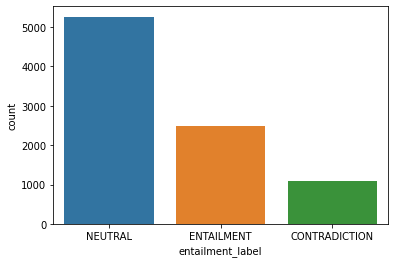

In [69]:
sns.countplot(df['entailment_label'], label = 'Inferência das Setenças');

In [11]:
pontuacoes = string.punctuation
pontuacoes

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [12]:
from spacy.lang.pt.stop_words import STOP_WORDS
stop_words = STOP_WORDS
print(stop_words)

{'dá', 'nove', 'alguns', 'quando', 'das', 'mais', 'cuja', 'dentro', 'até', 'momento', 'fez', 'à', 'contudo', 'muito', 'tempo', 'todas', 'quem', 'minhas', 'sete', 'parte', 'primeiro', 'tivemos', 'ele', 'tipo', 'um', 'conhecida', 'quais', 'deverá', 'foi', 'usar', 'cinco', 'daquela', 'eventual', 'sabe', 'aquelas', 'todos', 'direita', 'outros', 'for', 'quero', 'está', 'aquilo', 'fazia', 'nossa', 'vai', 'diante', 'ter', 'uns', 'agora', 'corrente', 'vão', 'faço', 'quê', 'vinte', 'sob', 'veja', 'ao', 'me', 'adeus', 'nada', 'estará', 'tuas', 'mesmo', 'vocês', 'depois', 'pela', 'eles', 'vez', 'comprida', 'nenhuma', 'dar', 'toda', 'disso', 'ademais', 'nuns', 'diz', 'lado', 'vens', 'parece', 'nem', 'aí', 'bem', 'só', 'atrás', 'nunca', 'saber', 'pode', 'cento', 'dezassete', 'próprio', 'somos', 'tentar', 'mil', 'porque', 'possível', 'tarde', 'local', 'porquê', 'números', 'mês', 'desde', 'foram', 'menos', 'sexta', 'querem', 'dizer', 'tanto', 'teus', 'quarta', 'terceira', 'contra', 'apoio', 'certeza'

In [13]:
len(stop_words)

413

In [14]:
pln = spacy.load('pt')
pln

In [16]:
dias = int(df.shape[0] * 0.2) # 20% do Dataset
train_df = df.iloc[:-dias,0:15].copy()
val_df = df.iloc[-dias:,0:15].copy()

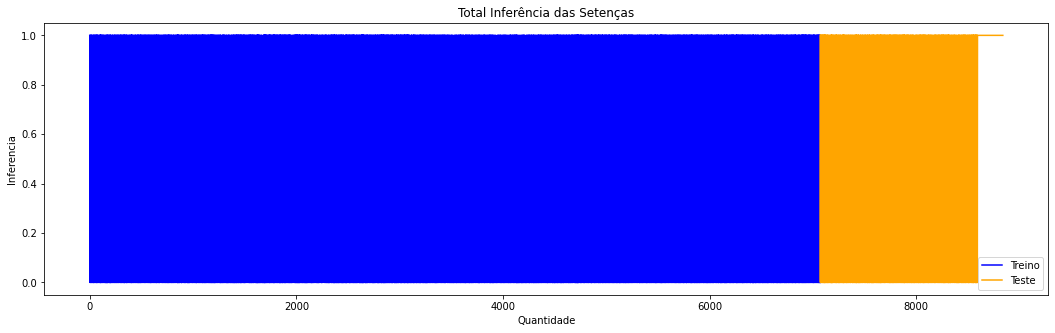

In [17]:
plt.figure(figsize=(18,5))
plt.title('Total Inferência das Setenças')
plt.plot(train_df['entailment_label']=='NEUTRAL', color='b')
plt.plot(val_df['entailment_label']=='NEUTRAL', color='orange')
plt.legend(['Treino','Teste'])
# plt.yticks(np.arange(0, 1000, step=50))
plt.xlabel('Quantidade')
plt.ylabel('Inferencia')
plt.show()

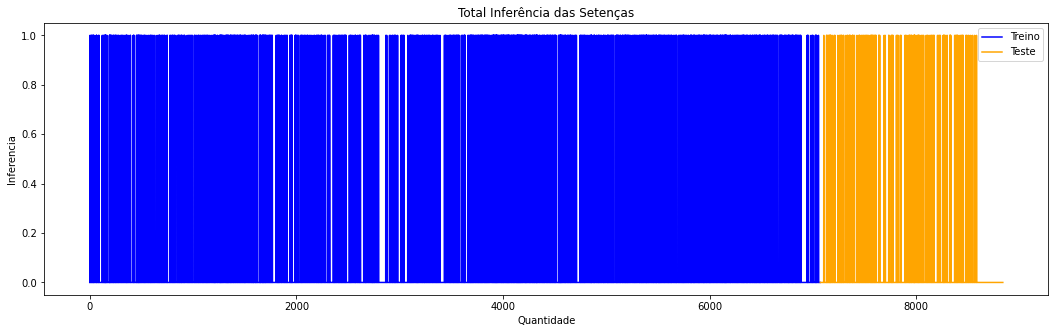

In [18]:
plt.figure(figsize=(18,5))
plt.title('Total Inferência das Setenças')
plt.plot(train_df['entailment_label']=='CONTRADICTION', color='b')
plt.plot(val_df['entailment_label']=='CONTRADICTION', color='orange')
plt.legend(['Treino','Teste'])
# plt.yticks(np.arange(0, 1000, step=50))
plt.xlabel('Quantidade')
plt.ylabel('Inferencia')
plt.show()

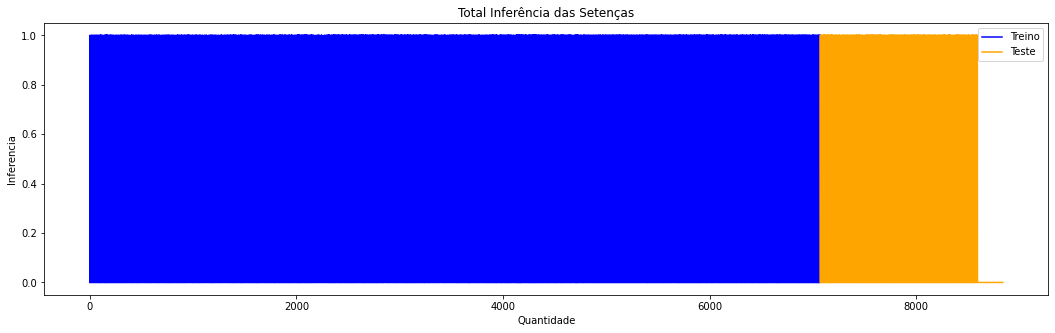

In [19]:
plt.figure(figsize=(18,5))
plt.title('Total Inferência das Setenças')
plt.plot(train_df['entailment_label']=='ENTAILMENT', color='b')
plt.plot(val_df['entailment_label']=='ENTAILMENT', color='orange')
plt.legend(['Treino','Teste'])
# plt.yticks(np.arange(0, 1000, step=50))
plt.xlabel('Quantidade')
plt.ylabel('Inferencia')
plt.show()

#### Model Fitted e Resultados do processo de treinamento (28/06/2021)

#### Execução com Held-Out-Data (Dados não vistos) (12/07/2021)

#### BERT

In [20]:
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pickle
import os
import transformers
from transformers import BertTokenizer

class MNLIDataBert(Dataset):

  def __init__(self, train_df, val_df):
    self.label_dict = {'ENTAILMENT': 0, 'CONTRADICTION': 1, 'NEUTRAL': 2}

    self.train_df = train_df
    self.val_df = val_df

    self.base_path = '/content/'
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) # Using a pre-trained BERT tokenizer to encode sentences
    self.train_data = None
    self.val_data = None
    self.init_data()

  def init_data(self):
    self.train_data = self.load_data(self.train_df)
    self.val_data = self.load_data(self.val_df)

  def load_data(self, df):
    MAX_LEN = 512
    token_ids = []
    mask_ids = []
    seg_ids = []
    y = []

    premise_list = df['sentence_A_tratado'].to_list()
    hypothesis_list = df['sentence_B_tratado'].to_list()
    label_list = df['entailment_label'].to_list()

    for (premise, hypothesis, label) in zip(premise_list, hypothesis_list, label_list):
      premise_id = self.tokenizer.encode(premise, add_special_tokens = False)
      hypothesis_id = self.tokenizer.encode(hypothesis, add_special_tokens = False)
      pair_token_ids = [self.tokenizer.cls_token_id] + premise_id + [self.tokenizer.sep_token_id] + hypothesis_id + [self.tokenizer.sep_token_id]
      premise_len = len(premise_id)
      hypothesis_len = len(hypothesis_id)

      segment_ids = torch.tensor([0] * (premise_len + 2) + [1] * (hypothesis_len + 1))  # sentence 0 and sentence 1
      attention_mask_ids = torch.tensor([1] * (premise_len + hypothesis_len + 3))  # mask padded values

      token_ids.append(torch.tensor(pair_token_ids))
      seg_ids.append(segment_ids)
      mask_ids.append(attention_mask_ids)
      y.append(self.label_dict[label])
    
    token_ids = pad_sequence(token_ids, batch_first=True)
    mask_ids = pad_sequence(mask_ids, batch_first=True)
    seg_ids = pad_sequence(seg_ids, batch_first=True)
    y = torch.tensor(y)
    dataset = TensorDataset(token_ids, mask_ids, seg_ids, y)
    print(len(dataset))
    return dataset

  def get_data_loaders(self, batch_size=32, shuffle=True):
    train_loader = DataLoader(
      self.train_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    val_loader = DataLoader(
      self.val_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    return train_loader, val_loader
  
mnli_dataset = MNLIDataBert(train_df, val_df)


7072
1768


In [21]:
train_loader, val_loader = mnli_dataset.get_data_loaders(batch_size=16)

In [22]:
from transformers import BertForSequenceClassification, AdamW

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [23]:
from transformers import BertForSequenceClassification, AdamW

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, correct_bias=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 109,484,547 trainable parameters


In [25]:
def multi_acc(y_pred, y_test):
  acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
  return acc

In [26]:
def multi_acc(y_pred, y_test):
  acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
  return acc

import time

EPOCHS = 5

def train(model, train_loader, val_loader, optimizer):  
  total_step = len(train_loader)

  for epoch in range(EPOCHS):
    start = time.time()
    model.train()
    total_train_loss = 0
    total_train_acc  = 0
    for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(train_loader):
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      seg_ids = seg_ids.to(device)
      labels = y.to(device)

      loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()

      acc = multi_acc(prediction, labels)

      loss.backward()
      optimizer.step()
      
      total_train_loss += loss.item()
      total_train_acc  += acc.item()

    train_acc  = total_train_acc/len(train_loader)
    train_loss = total_train_loss/len(train_loader)
    model.eval()
    total_val_acc  = 0
    total_val_loss = 0
    with torch.no_grad():
      for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(val_loader):
        optimizer.zero_grad()
        pair_token_ids = pair_token_ids.to(device)
        mask_ids = mask_ids.to(device)
        seg_ids = seg_ids.to(device)
        labels = y.to(device)
        
        loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()
        
        acc = multi_acc(prediction, labels)

        total_val_loss += loss.item()
        total_val_acc  += acc.item()

    val_acc  = total_val_acc/len(val_loader)
    val_loss = total_val_loss/len(val_loader)
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

In [27]:
train(model, train_loader, val_loader, optimizer)

Epoch 1: train_loss: 0.7893 train_acc: 0.6561 | val_loss: 0.5867 val_acc: 0.7534
00:44:13.53
Epoch 2: train_loss: 0.5799 train_acc: 0.7646 | val_loss: 0.5670 val_acc: 0.7556
00:44:36.48
Epoch 3: train_loss: 0.4946 train_acc: 0.8101 | val_loss: 0.5814 val_acc: 0.7590
00:45:22.09
Epoch 4: train_loss: 0.4288 train_acc: 0.8358 | val_loss: 0.6204 val_acc: 0.7663
00:46:05.01
Epoch 5: train_loss: 0.3739 train_acc: 0.8648 | val_loss: 0.6293 val_acc: 0.7652
00:45:42.85
